<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C5NP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
import pandas as pd

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
mod  = test.index % 5
test_add = test.loc[ mod != 0 ,:]
test_50 = test.loc[ mod == 0 ,:]

# def train,test,features,y_name

In [3]:
features = ['T10','T50','T90','N+A']
y_name = 'C5NP'
train = train.append(test_add)[features+[y_name]]
test = test_50[features+[y_name]]
print(train.shape)
print(test.shape)

(4721, 5)
(50, 5)


# describe

In [4]:
train.describe()

,T10,T50,T90,N+A,C5NP
count,4721.000000,4721.000000,4721.000000,4721.000000,4721.000000
mean,95.216280,115.395742,144.440530,40.815614,1.800642
std,11.551752,6.838592,4.683146,8.437211,2.333936
min,47.100000,83.000000,121.500000,20.570000,0.000000
25%,91.900000,113.000000,142.500000,33.133000,0.181000
50%,99.000000,117.500000,144.500000,38.282000,1.025000
75%,103.700000,119.900000,146.400000,48.938000,2.168000
max,116.900000,131.700000,198.500000,69.540000,16.611529


# corr

In [5]:
train.corr()

,T10,T50,T90,N+A,C5NP
T10,1.000000,0.895238,0.222087,-0.262210,-0.938402
T50,0.895238,1.000000,0.533778,-0.371996,-0.804852
T90,0.222087,0.533778,1.000000,-0.217989,-0.140439
N+A,-0.262210,-0.371996,-0.217989,1.000000,0.186861
C5NP,-0.938402,-0.804852,-0.140439,0.186861,1.000000


In [0]:
#根據corr 選擇重要特徵
features = ['T10']

# kde

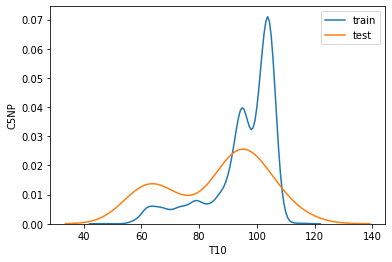

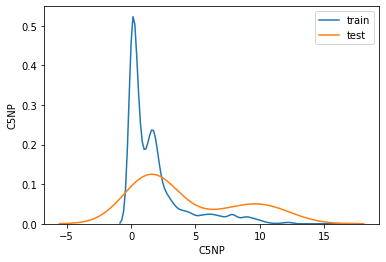

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in features+[y_name]:
  sns.kdeplot(data = train[col],label='train')
  sns.kdeplot(data = test[col],label='test')
  plt.legend();plt.xlabel(col);plt.ylabel(y_name)
  plt.show()

# scatter

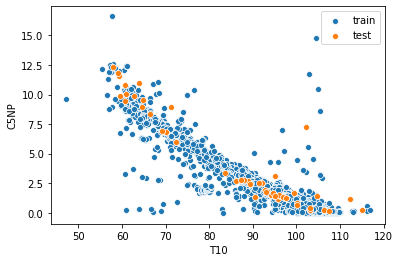

In [8]:
for x_col in features:
  sns.scatterplot(x=x_col,y=y_name,data=train,label='train')
  sns.scatterplot(x=x_col,y=y_name,data=test,label='test')
  plt.legend()
  plt.show()

# scaler

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[y_t.name])

# modeling

In [12]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
import warnings 
warnings.simplefilter('ignore')

#model = xgboost.XGBRegressor(objective='reg:squarederror')
model = SVR(C=2)
#model = LinearRegression()

val_scores = cross_validate(model,train[features],train[y_name],cv=5)

print('val_scores:',val_scores['test_score'])
print('val_scores.mean:',val_scores['test_score'].mean())

# fit 
model.fit(train[features],train[y_name])
# predict
test['y_pred'] = model.predict(test[features])

# metric
print('test_scores:')
metric(test[y_name],test['y_pred'])


val_scores: [0.85819305 0.70989492 0.96090031 0.92181494 0.92903429]
val_scores.mean: 0.8759675024088882
test_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.900071,1.233188,0.658139


# tree

In [0]:
#xgboost.to_graphviz(model)

# line plot

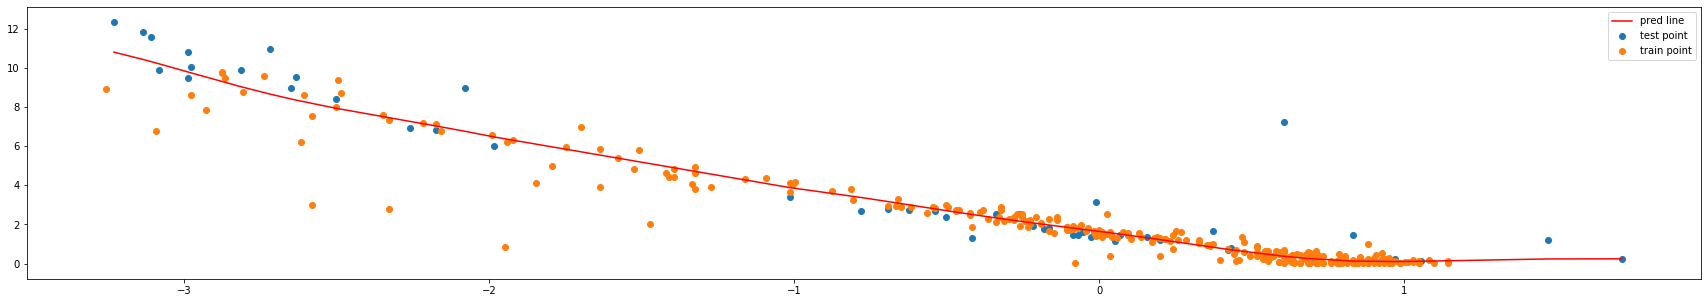

In [14]:
fig = plt.figure(figsize=(30,5))

test_point = test.sort_values(by='T10')
train_sample_point = train.sample(300).sort_values(by='T10')

plt.plot(test_point['T10'],test_point['y_pred'],label='pred line',color='red')

plt.scatter(test_point['T10'],test_point[y_name],label='test point')

plt.scatter(train_sample_point['T10'],train_sample_point[y_name],label='train point')

plt.legend()
plt.show()

# check out

In [15]:
loss = (test_point[y_name] - test_point['y_pred'])**2 # 平方誤差
loss.sort_values(ascending=False).head(5)

95     46.902675
100     5.266154
150     4.814340
30      2.387610
60      2.125880
dtype: float64

# del out

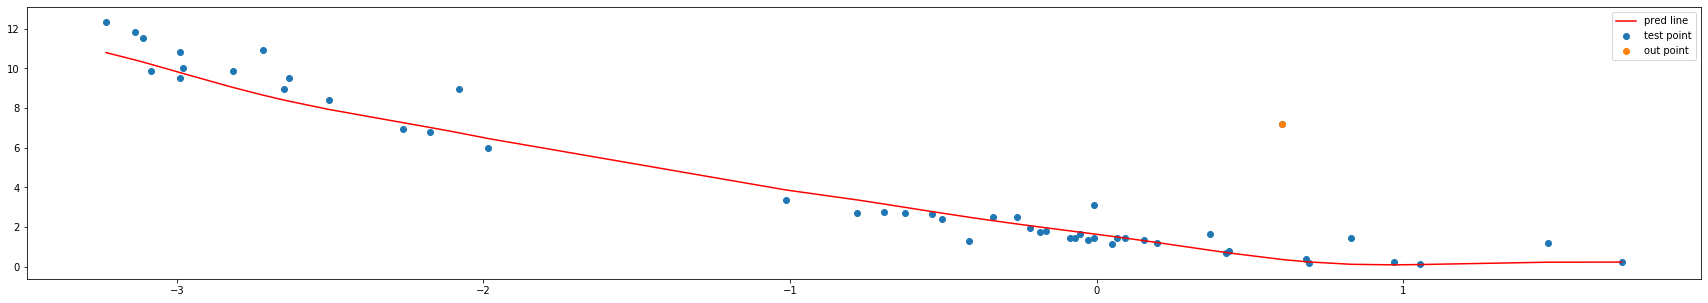

In [16]:
#add out columns
test_point['out'] = False
test_point.loc[loss.sort_values(ascending=False).head(1).index,'out'] = True

#fig
fig = plt.figure(figsize=(30,5))

#sort test point
test_point = test_point.sort_values(by='T10')

#def out_point
out_point = test_point[test_point['out'] == True]

#y_pred line
plt.plot(test_point['T10'],test_point['y_pred'],label='pred line',color='red')

#test point
plt.scatter(test_point['T10'],test_point[y_name],label='test point')

#out point
plt.scatter(out_point['T10'],out_point[y_name],label='out point')

plt.legend()
plt.show()

# del_out_point_scores:

In [17]:
print('del_out_point_scores:')
metric(test_point.loc[test_point['out'] == False ,y_name],test_point.loc[test_point['out'] == False ,'y_pred'])

del_out_point_scores:


,R2,RMSE,mean_absolute_error
C5NP,0.961251,0.771098,0.531804
